# Backgroud Subtraction using Averaging method, K-Means and Gaussian Mixture Models

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from google.colab.patches import cv2_imshow

In [47]:
from scipy.stats import multivariate_normal
class GMM(object):
    
    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.reg_cov = 1e-6*np.identity(len(X[0]))

    def initialize_params(self, X, kmeans=False):
       
        self.n, self.m = X.shape
        self.phi = np.full(shape=self.n_components, fill_value=1/self.n_components)
        self.weights = np.full(shape=X.shape, fill_value=1/self.n_components)

        random_row = np.random.randint(low=0, high=self.n, size=self.n_components)
        self.mu = [  X[i,:] for i in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.n_components) ]
  
    def E_step(self, X):

        likelihood = np.zeros((self.n, self.n_components))
       
        for i in range(self.n_components):
          distribution=multivariate_normal(mean = self.mu[i], cov=self.sigma[i]+self.reg_cov, allow_singular=True)
          likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]

        self.weights = numerator/denominator
        self.phi = self.weights.mean(axis=0)

    def M_step(self, X):
        
        for i in range(self.n_components):
          weight = self.weights[:, [i]]
          total_weight = weight.sum()
          self.mu[i] = (X * weight).sum(axis=0) / total_weight
          self.sigma[i] = np.cov(X.T, aweights=(weight/total_weight).flatten(), bias=True)

    def fit(self, X, y=None):
       
        self.initialize_params(X)
        
        for iteration in range(self.max_iter):
          self.E_step(X)
          self.M_step(X)
        return self.mu, self.sigma, self.phi
        
    def predict(self, X):
        
        self.n, self.m = X.shape
        likelihood = np.zeros((self.n, self.n_components))
      
        for i in range(self.n_components):
          distribution=multivariate_normal(mean = self.mu[i], cov=self.sigma[i]+self.reg_cov, allow_singular=True)
          likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]

        weights = numerator/denominator
        return np.argmax(weights, axis=1)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Background Subtraction

- Foreground detection is one of the major tasks in the field of computer vision and image processing, whose aim is to detect changes in image sequences. 
- Background subtraction is any technique which allows an image's foreground to be extracted for further processing (object recognition, etc.).

One of the most important applications of this is Foreground Detection on Highways for speeding vehicles. 
Before the Deep Learning age, methods using GMMs were considered very effective in accurately detecting vehicles on highways. 

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly. As you can see one of the drawbacks of simply doing this is that changing environments and lighting would severly affect this method, so we are also going to explore Adaptive GMM which takes care of such problems.

(Note: The Segmentation GIF show below is a reference for the expected output, and since it is extracted just from the test frames, it is not in sync with the full GIF given above, so don't be confused)

(Another Note: The Segmentation GIF displays everything that is not the background, i.e. foreground objects, in White, and not just the white cars.)

![reference](./extras/traffic_reference.gif)

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Hint: Most of the time, the Gaussian with the higher weight corresponds to the background.
    - Hint-2: We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to (baseline - 1).
    To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    This method is much simpler to implement but, this could give worse results.
    
3. K-Means Per Pixel:
    - Similar approach to GMMs per pixel.

4. Adaptive GMM Per Pixel (Not part of the assignment):
    - We can update GMMs without fitting them for every subsequent frame.
    - The biggest advantage of this method is that it can be used in real time tracking and will also adapt to change in environments and lighting.
    - Note: This is not part of the assignment, only meant for enthusiasts who want to explore.

### Extracting Frames from videos

In [58]:
source_folder = 'drive/MyDrive/SMAI_Assignment_3_v3/Q2/videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'
source_path

'./drive/MyDrive/SMAI_Assignment_3_v3/Q2/videos/traffic.gif'

In [59]:
data_folder = 'drive/MyDrive/SMAI_Assignment_3_v3/Q2/frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"
# print(frames_path)
import os
# print(os.getcwd())

In [60]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [61]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

### Loading Frames

In [62]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.asarray(img, dtype=np.float64)
    img /= 255.0
    
    frames.append(img)
    
frames = np.asarray(frames, dtype=np.float64)

In [63]:
from google.colab.patches import cv2_imshow
import numpy as np

cap = cv2.VideoCapture(source_path)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()
frames = np.asarray(frames, dtype=np.float64)

In [64]:
frames.shape

(80, 120, 160, 3)

### Splitting the data

In [65]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

# train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=True, random_state=1)
train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


## 1. Frame Averaging

### Extract Background Image from the training data

In [66]:
def frameAvg(frames):
  background = np.mean(frames, axis=0)
  cv2_imshow(background)
  return background

### Visualize 

In [67]:
def visualize1(pred, filename):
  print("Display Frames: ")
  display_frames(pred)
  print("Saving Frames: ")
  save_frames(pred,file_name = filename)

## 2. GMMs per pixel

### Create Set of GMMs for every pixel and fit them considering every training frame

In [83]:
gmm = GMM(n_components = 2, tol=0.001, max_iter=10)
background_g = np.zeros(shape=(frames.shape[1:]))

for i in range(frames.shape[1]):
    for j in range(frames.shape[2]):
        for k in range(frames.shape[3]):
            X = frames[:, i, j, k]
            X = X.reshape(X.shape[0], 1)
            means, covars, weights = gmm.fit(X)
            idx = np.argmax(weights)
            background_g[i][j][k] = int(means[idx])

### Extract Background Image from the trained model

In [50]:
#  cv2.imwrite('background1.png', background)

True

### Visualize 

In [84]:
def visualize2(pred, filename):
  print("Display Frames: ")
  display_frames(pred)
  print("Saving Frames: ")
  save_frames(pred,file_name = filename)

## 3. Extracting Background using K-Means

In [85]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init = 'auto', random_state=0)
background_k = np.zeros(shape=(frames.shape[1:]))

for i in range(frames.shape[1]):
    for j in range(frames.shape[2]):
        for k in range(frames.shape[3]):
            X = frames[:, i, j, k]
            X = X.reshape(X.shape[0], 1)
            kmeans.fit(X)
            labels = kmeans.labels_
            centers = kmeans.cluster_centers_
            label0 = list(labels).count(0)
            label1 = list(labels).count(1)
            if(label0 >= label1):
              background_k[i][j][k] = centers[0]
            else:
              background_k[i][j][k] = centers[1]

<ipython-input-85-5110f52cc8f8>:10: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X)
<ipython-input-85-5110f52cc8f8>:10: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X)
<ipython-input-85-5110f52cc8f8>:10: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X)


### Extract Background Image from the trained model

### Visualize 

In [86]:
def visualize3(pred, filename):
  print("Display Frames: ")
  display_frames(pred)
  print("Saving Frames: ")
  save_frames(pred,file_name = filename)

### Displaying frames as videos

In [69]:
def display_frames(frames, fps=10.0):
    eps = 0.0001
    
    wait_time = int(1000 // fps)
    
    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        threshold_value = 100
        _, img_thresholded = cv2.threshold(frame, threshold_value, 255, cv2.THRESH_BINARY_INV)
        
        cv2_imshow(img_thresholded)
        
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break
    
    cv2.destroyAllWindows()

### Saving frames as videos

In [79]:
os.makedirs('./drive/MyDrive/SMAI_Assignment_3_v3/Q2/results', exist_ok=True)

In [80]:
def save_frames(frames, file_name, fps=10.0, output_path='./drive/MyDrive/SMAI_Assignment_3_v3/Q2/results'):
    eps = 0.0001
    
    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")
    # save_path = os.path.join(output_path, f"{file_name.rsplit('.')[0]}.avi")
    
    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        threshold_value = 100
        _, img_thresholded = cv2.threshold(frame, threshold_value, 255, cv2.THRESH_BINARY_INV)
        
        print(img_thresholded.shape)
        cv2_imshow(img_thresholded)

        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
        
        vid_wrt.write(img_thresholded)

        
    vid_wrt.release()
    cv2.destroyAllWindows()

### 1. Frame Averaging

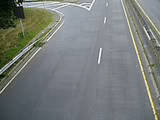

In [81]:
background_A = frameAvg(train_frames)
y_pred1 = test_frames - background_A

Display Frames: 


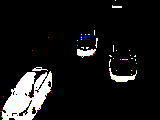

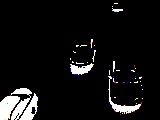

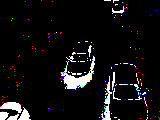

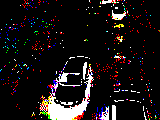

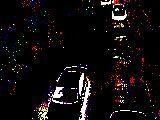

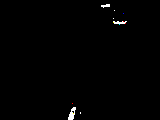

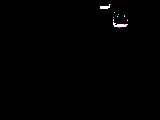

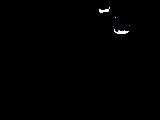

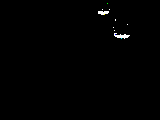

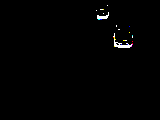

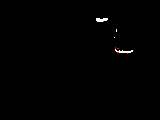

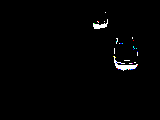

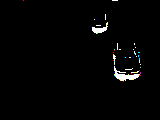

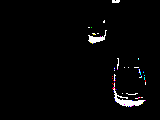

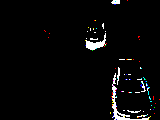

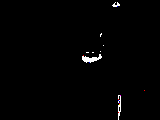

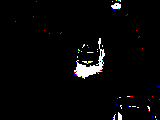

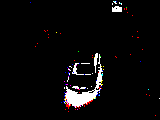

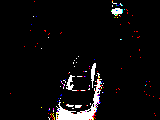

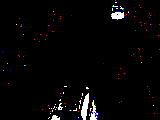

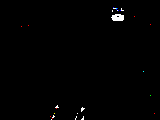

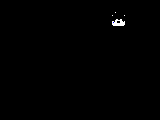

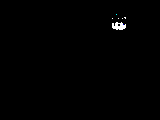

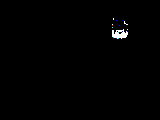

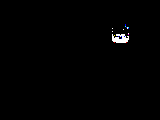

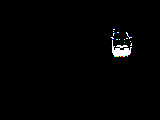

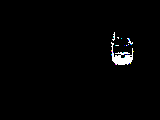

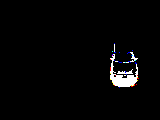

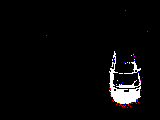

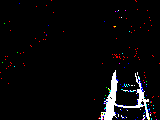

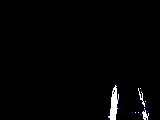

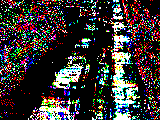

Saving Frames: 
(120, 160, 3)


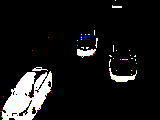

(120, 160, 3)


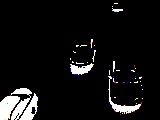

(120, 160, 3)


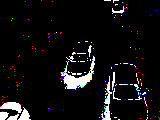

(120, 160, 3)


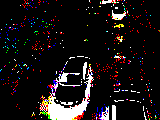

(120, 160, 3)


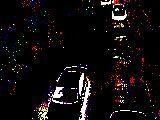

(120, 160, 3)


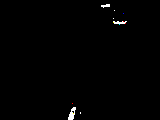

(120, 160, 3)


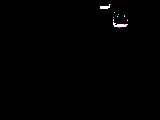

(120, 160, 3)


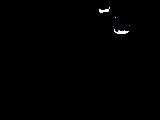

(120, 160, 3)


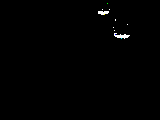

(120, 160, 3)


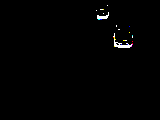

(120, 160, 3)


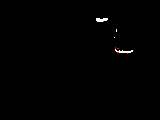

(120, 160, 3)


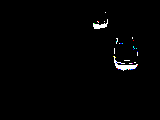

(120, 160, 3)


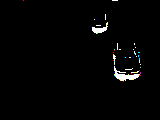

(120, 160, 3)


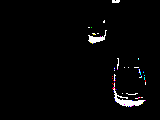

(120, 160, 3)


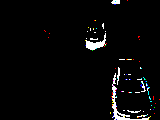

(120, 160, 3)


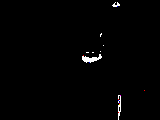

(120, 160, 3)


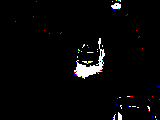

(120, 160, 3)


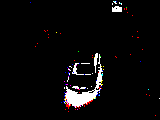

(120, 160, 3)


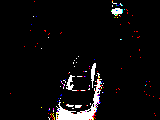

(120, 160, 3)


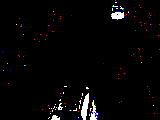

(120, 160, 3)


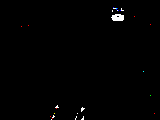

(120, 160, 3)


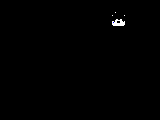

(120, 160, 3)


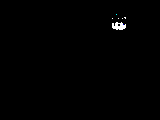

(120, 160, 3)


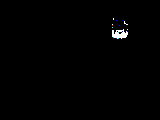

(120, 160, 3)


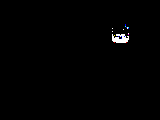

(120, 160, 3)


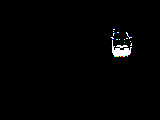

(120, 160, 3)


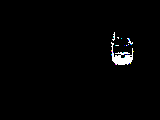

(120, 160, 3)


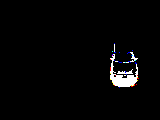

(120, 160, 3)


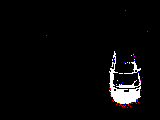

(120, 160, 3)


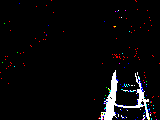

(120, 160, 3)


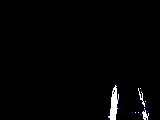

(120, 160, 3)


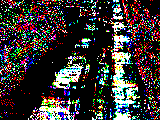

In [82]:
visualize1(y_pred1, 'avg_BS')

### 2. GMMs per pixel

In [87]:
y_pred2 = test_frames - background_g

Display Frames: 


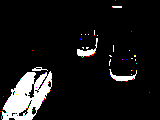

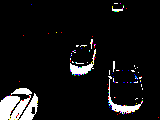

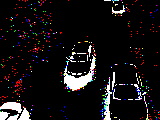

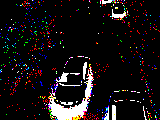

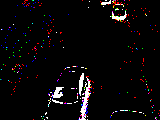

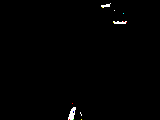

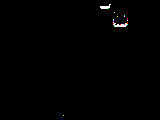

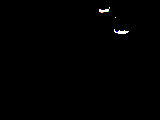

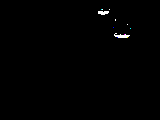

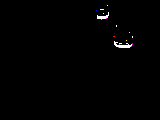

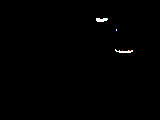

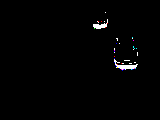

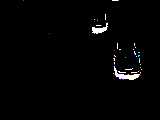

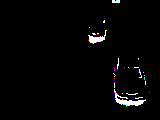

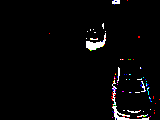

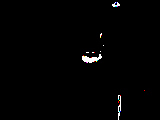

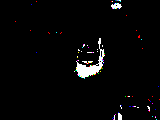

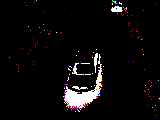

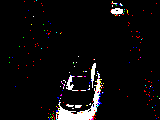

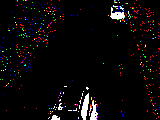

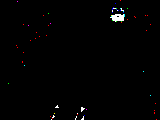

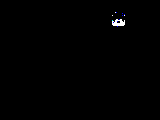

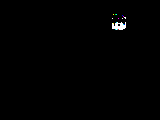

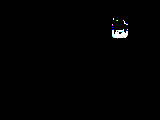

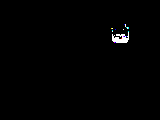

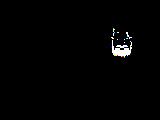

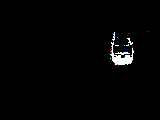

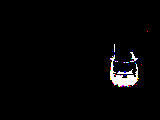

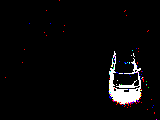

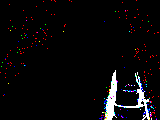

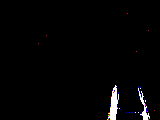

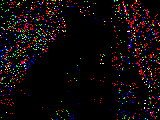

Saving Frames: 
(120, 160, 3)


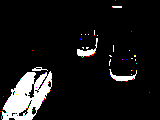

(120, 160, 3)


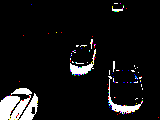

(120, 160, 3)


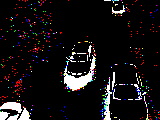

(120, 160, 3)


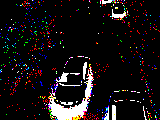

(120, 160, 3)


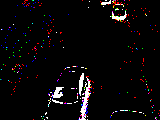

(120, 160, 3)


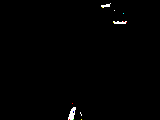

(120, 160, 3)


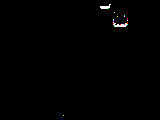

(120, 160, 3)


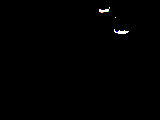

(120, 160, 3)


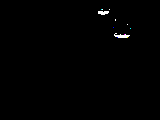

(120, 160, 3)


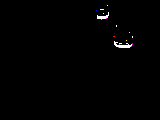

(120, 160, 3)


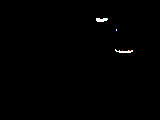

(120, 160, 3)


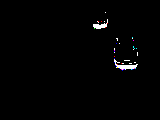

(120, 160, 3)


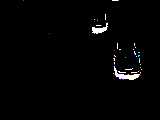

(120, 160, 3)


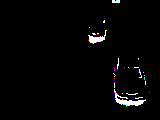

(120, 160, 3)


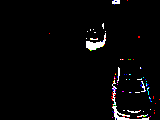

(120, 160, 3)


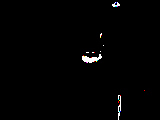

(120, 160, 3)


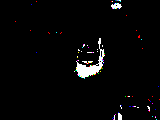

(120, 160, 3)


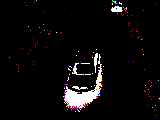

(120, 160, 3)


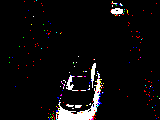

(120, 160, 3)


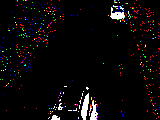

(120, 160, 3)


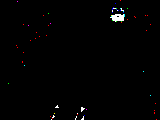

(120, 160, 3)


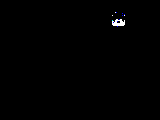

(120, 160, 3)


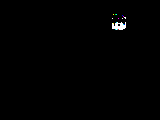

(120, 160, 3)


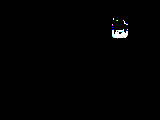

(120, 160, 3)


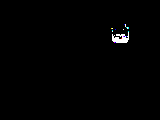

(120, 160, 3)


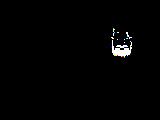

(120, 160, 3)


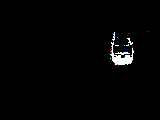

(120, 160, 3)


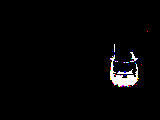

(120, 160, 3)


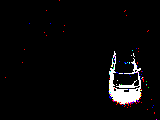

(120, 160, 3)


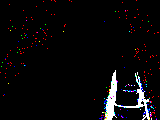

(120, 160, 3)


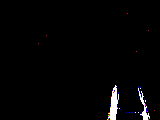

(120, 160, 3)


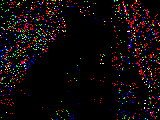

In [88]:
visualize2(y_pred2, 'gmm_BS')

### 3. KMeans per pixel

- You can use `sklearn.cluster.KMeans` for this classification

In [89]:
y_pred3 = test_frames - background_k

Display Frames: 


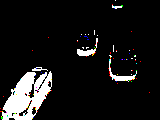

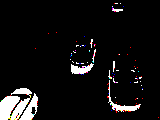

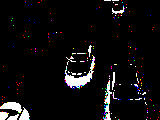

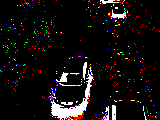

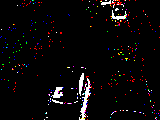

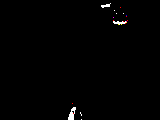

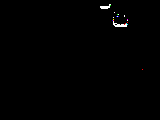

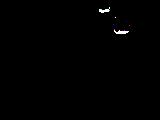

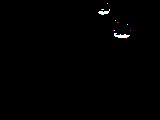

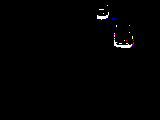

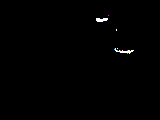

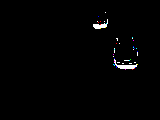

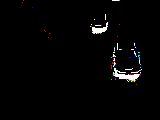

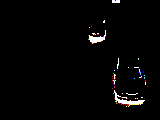

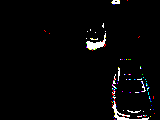

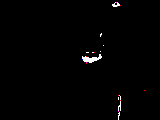

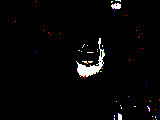

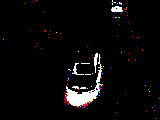

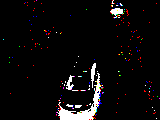

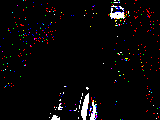

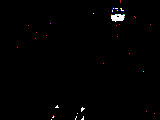

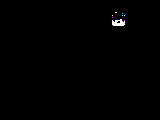

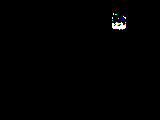

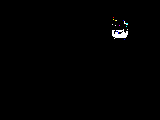

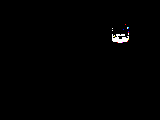

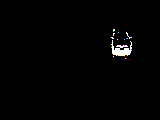

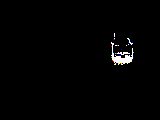

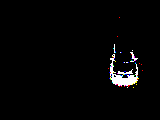

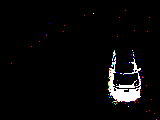

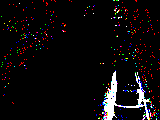

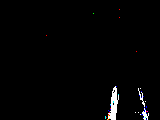

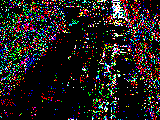

Saving Frames: 
(120, 160, 3)


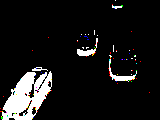

(120, 160, 3)


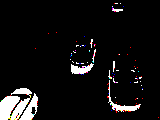

(120, 160, 3)


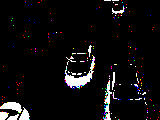

(120, 160, 3)


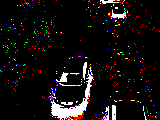

(120, 160, 3)


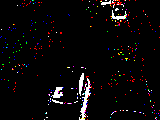

(120, 160, 3)


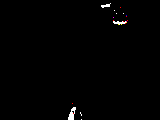

(120, 160, 3)


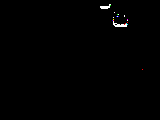

(120, 160, 3)


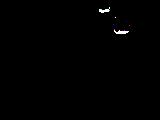

(120, 160, 3)


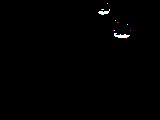

(120, 160, 3)


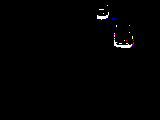

(120, 160, 3)


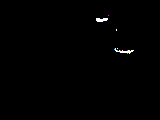

(120, 160, 3)


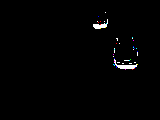

(120, 160, 3)


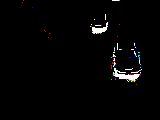

(120, 160, 3)


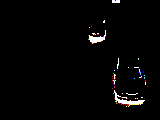

(120, 160, 3)


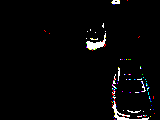

(120, 160, 3)


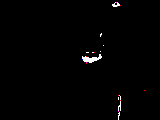

(120, 160, 3)


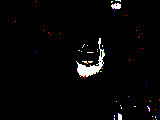

(120, 160, 3)


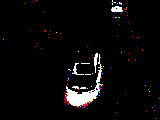

(120, 160, 3)


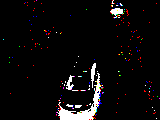

(120, 160, 3)


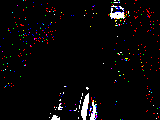

(120, 160, 3)


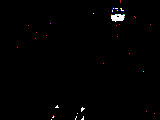

(120, 160, 3)


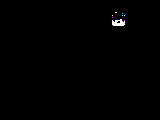

(120, 160, 3)


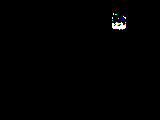

(120, 160, 3)


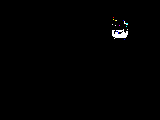

(120, 160, 3)


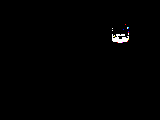

(120, 160, 3)


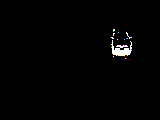

(120, 160, 3)


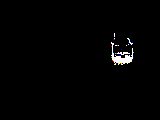

(120, 160, 3)


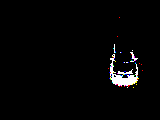

(120, 160, 3)


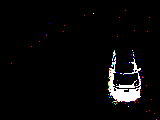

(120, 160, 3)


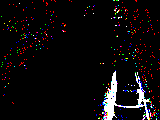

(120, 160, 3)


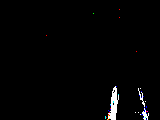

(120, 160, 3)


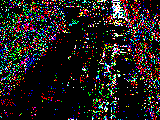

In [90]:
visualize3(y_pred3, 'kmeans_BS')

## 4. Adaptive (Not part of the assignment)
- Reference Paper: http://www.ai.mit.edu/projects/vsam/Publications/stauffer_cvpr98_track.pdf
- Video: https://youtu.be/0nz8JMyFF14
- This part is just for enthusiasts who want to explore some stuff.

In [ ]:
"""
Your code here
"""

'\nYour code here\n'